# Final assignment

## Stan warm-up: linear model of BDA retention with Stan

Mistakes:
- No ";" at the end of the line: `vector[N] mu = alpha + beta * x // linear model`
- used upper instead of lower
- we didn't sample from predictive distribution, but just with the mu parameter

+1) While this might not be an issue in another language, but I also had to delete the "#<1>" and alike parts from the code.

In [1]:
import stan
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

lin_normal_model = """
data {
// number of data points
int<lower=0> N;
// covariate / predictor
vector[N] x;
// observations
vector[N] y;
// number of covariate values to make predictions at
int<lower=0> no_predictions;
// covariate values to make predictions at
vector[no_predictions] x_predictions;
} 
parameters { 
// intercept
real alpha;
// slope
real beta;
// the standard deviation should be constrained to be positive
real<lower=0> sigma;
} 
transformed parameters { 
// deterministic transformation of parameters and data
vector[N] mu = alpha + beta * x; // linear model
} 
model { 
// observation model / likelihood
y ~ normal(mu, sigma);
} 
generated quantities { 
// compute the means for the covariate values at which to make predictions
vector[no_predictions] mu_pred = alpha + beta * x_predictions;
// sample from the predictive distribution, a normal(mu_pred, sigma).
array[no_predictions] real y_pred = normal_rng(mu_pred, sigma);
}
"""

Let's fix it, and try it on some random data.

y should be somewhere between 0 and 1 by the description (proportion of correct answers). The variable x represent something related to the assignments, I just choose it to be an integer between 1 and 9.

I choose `alpha=0.2, beta=0.05`, and `sigma=0.1`. It could happen with a small chance that the generated data is not in the range of 0 and 1, this is not important to just check if the model works.

In [38]:
np.random.seed(20001104)
N = 100
x = np.random.randint(1, 10, N)
alpha_real = 0.2
beta_real = 0.05
sigma_real = 0.1
y = alpha_real + beta_real * x + np.random.normal(0, sigma_real, N)
no_predictions = 1000 #same as N, just for plotting
x_predictions = np.linspace(1, 10, no_predictions) #something simple

data = {'N': N, 'x': x, 'y': y, 'no_predictions': no_predictions, 'x_predictions': x_predictions}
posterior = stan.build(lin_normal_model, data=data, random_seed=20001104)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


The warning only appears because we didn't have to define a prior for the uniform distribution, Stan uses by default uniform priors. <br>
Since our prior is uniform, our posterior is proportional to the likelihood.

We sample from the posterior - this is the process: each step an alpha, beta and sigma is drawn from the posterior distribution (an approximate of it), we calculate the mu value, and y is generated from a normal distribution with mu and sigma. After sampling, we generate mu_pred, and for  draw 1000 samples of y_pred from a normal distribution with mu_pred and sigma.

The MCMC standard error is $\sigma / \sqrt{s} = 0.1 / \sqrt{1000} \approx 0.0032$. The precision should be around 2-3 decimal places, I choose to round it to 3 and give the $[x-3\sigma, x+3\sigma]$ 95% interval. For other attributes, the standard deviation is even smaller.

In [54]:
def attribute_mcmc_std_err(x_samples):
      return np.std(x_samples)/np.sqrt((x_samples).shape[1])

np.random.seed(20001104)
fit = posterior.sample(num_chains=1, num_samples=no_predictions)

alpha_samples = fit['alpha']
beta_samples = fit['beta']
sigma_samples = fit['sigma']
y_pred_samples = fit['y_pred']

alpha_mcmc_std_err = attribute_mcmc_std_err(alpha_samples)
beta_mcmc_std_err = attribute_mcmc_std_err(beta_samples)
sigma_mcmc_std_err = attribute_mcmc_std_err(sigma_samples)
print("\n", fit)
print("Mean of alpha: ", 
      np.round(alpha_samples.mean() -3*alpha_mcmc_std_err, 3)," - ", 
      np.round(alpha_samples.mean() +3*alpha_mcmc_std_err, 3),
      "\nMean of beta: ", 
      np.round(beta_samples.mean() - 3*beta_mcmc_std_err, 3), " - ",
      np.round(beta_samples.mean() + 3*beta_mcmc_std_err, 3),
      "\nMean of sigma: ",
      np.round(sigma_samples.mean() - 3*sigma_mcmc_std_err, 3), " - ",
      np.round(sigma_samples.mean() + 3*sigma_mcmc_std_err, 3)
      )

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000386 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.86 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_u9xoxgjs/model_p43jlqkk.stan', line 28, column 0 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



 <stan.Fit>
Parameters:
    alpha: ()
    beta: ()
    sigma: ()
    mu: (100,)
    mu_pred: (1000,)
    y_pred: (1000,)
Draws: 1000
Mean of alpha:  0.191  -  0.195 
Mean of beta:  0.052  -  0.053 
Mean of sigma:  0.107  -  0.108


The values of $\alpha$, $\beta$ and $\sigma$ are close to the true values (surprisingly low values for $\alpha$), meaning that the code works well.

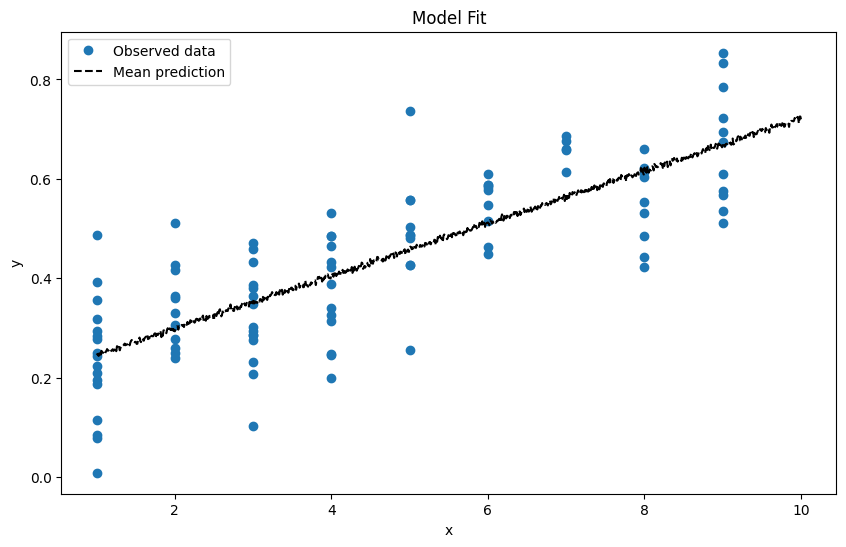

In [55]:
# Plot the fit
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Observed data')
plt.plot(x_predictions, np.mean(y_pred_samples, axis=1), 'k--', label='Mean prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Fit')
plt.legend()
plt.show()

The sampling was correct - the " blue lines" represent the different integer x values and their sampled y values, we see the correct increasing trend for both the real and the average predicted values.

## Generalized linear model: Bioassay with Stan

### Data:

From the slides, the table:

| Dose (log g/ml) | No. of Animals | No. of Deaths |
|------|----------------|---------------|
| -0.86  | 5              | 0             |
| -0.30  | 5              | 1             |
| -0.05  | 5              | 3             |
|  0.73  | 5              | 5             |

### 3.a) Model

We need to model the data with a binomial likelihood (with a logit link function), the priors should be multinormally distributed.<br>
We can take inspiration from the slides:


Binomial model of likelihood:
$$y_i | θ_i ∼ Bin(θ_i, n_i)$$

Link function (logistic regression, so it goes from 0 to 1):
$$logit(θ_i) = α + βx_i$$

(Likelihood in complete form: $p(y_i | α, β, n_i, x_i) ∝ [logit^{−1}(α + βx_i)]^{y_i} [1 − logit^{−1}(α + βx_i)]^{ni−yi} $

We can write similar code as in the first task for the model, but now we have to define the priors in the model.<br>
I tried to implement prediction on new data, but there was no `binomial_logit_rng` function and the attempted code ran out of memory.

In [2]:
binomial_logit_model = """
data{
int<lower=0> N;
vector[N] x; //input
array[N] int <lower=0> n;
array[N] int <lower=0> y;
vector[2] mean0;
matrix<lower=0>[2, 2] covar0;
//int<lower=0> no_predictions;
//vector[no_predictions] x_predictions;
}
parameters{
vector[2] t;
}
transformed parameters {
real alpha = t[1];
real beta = t[2];
vector[N] theta = alpha + beta * x;
}
model {
t ~ multi_normal(mean0, covar0);
y ~ binomial_logit(n, theta); //Likelihood binomial-logit
}
generated quantities {
  //vector[N] theta_pred = alpha + beta * x_predictions;
  //array[no_predictions] real y_pred = binomial_rng(n, inv_logit(theta_pred));
}
"""

np.random.seed(20001104)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])
mean0 = np.array([0, 10])
covar0 = np.array([[4, 12], [12, 100]])
#no_predictions = 3
#x_predictions = np.array([-1, 0, 1])

data = {'N': len(x), 'x': x, 'n': n, 'y': y, 'mean0': mean0, 'covar0': covar0,
        #'no_predictions': no_predictions, 'x_predictions': x_predictions
        }

# Build and sample the model
posterior = stan.build(binomial_logit_model, data=data, random_seed=20001104)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


We can try 10 separate chains (we have 4 datapoints, we shouldn't expect to recover the real distribution from these 4 points, so we only aim at maximum 4 modes, and hopefully 10 chains will have at least one in each of them)

### Convergence analysis

We want to sample til ($\hat{R}$) is very close to 1.

In [3]:
fit = posterior.sample(num_chains=10, num_samples=1000)
#Gather the samples into a dataframe, and then use df.describe() to get the summary statistics

Sampling:   0%
Sampling:  10% (2000/20000)
Sampling:  20% (4000/20000)
Sampling:  30% (6000/20000)
Sampling:  40% (8000/20000)
Sampling:  50% (10000/20000)
Sampling:  60% (12000/20000)
Sampling:  70% (14000/20000)
Sampling:  80% (16000/20000)
Sampling:  90% (18000/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 0.000201 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust 

In [4]:
import arviz as az
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t[0],0.960,0.927,-0.668,2.795,0.017,0.012,3024.0,4164.0,1.0
t[1],10.546,4.678,2.702,19.188,0.086,0.062,3102.0,4031.0,1.0
alpha,0.960,0.927,-0.668,2.795,0.017,0.012,3024.0,4164.0,1.0
beta,10.546,4.678,2.702,19.188,0.086,0.062,3102.0,4031.0,1.0
theta[0],-8.109,3.520,-14.855,-2.347,0.060,0.043,3660.0,4635.0,1.0
theta[1],-2.203,1.098,-4.283,-0.231,0.015,0.011,6210.0,5525.0,1.0
theta[2],0.433,0.802,-1.057,1.968,0.013,0.010,3573.0,4428.0,1.0
theta[3],8.659,4.058,1.816,16.226,0.078,0.055,2808.0,3964.0,1.0


What we see from the summary, is that the $\hat{R}$ values for both $\alpha$ and $\beta$ are stored as 1.0, assuring us that there is no between chains variance. This is as good as it gets.

It would be interesting to see how the $\hat{R}$ values change with the step number, and when does it reach 1.0.

### Plotting $\alpha$ and $\beta$

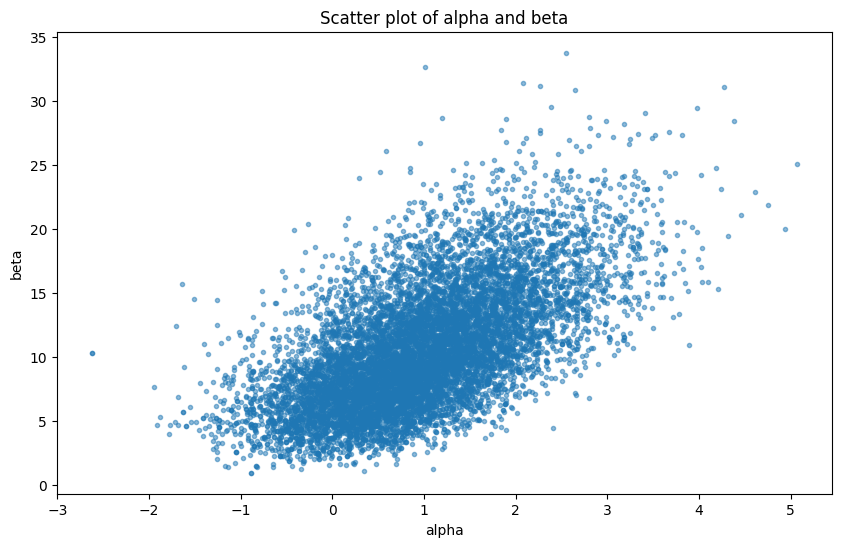

In [7]:
#Plot the draws for α and β (scatter plot)
alpha_samples = fit['alpha']
beta_samples = fit['beta']

plt.figure(figsize=(10, 6))
plt.scatter(alpha_samples, beta_samples, alpha=0.5, marker='.')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Scatter plot of alpha and beta')
plt.show()

This is the comparison plot, with less samples, and with uniform prior:

[![bioassay](https://raw.githubusercontent.com/me9hanics/pystan/refs/heads/main/BDA3plot.png)]


We can observe, that the $\alpha$ and $\beta$ values in our model are in the same range as in the slides, e.g. $\beta$ from 0 to ~40, with many values around 10-15. This is a sign that the model was implemented correctly.